Characterizations of data in iDigBio suitible for text mining

In [1]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
import pyspark.sql.functions as sql
#from pyspark.sql.functions import udf, length
import matplotlib.pyplot as plt
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Load iDigBio Parquet
sqlContext = SQLContext(sc)
idbdf = sqlContext.read.parquet("../data/idigbio/occurrence.txt.parquet")
#idbdf = sqlContext.read.parquet("../data/idigbio-100k/occurrence.txt.parquet")
total_records = idbdf.count()
print(total_records)

15457224


Let's start with the assumption that we know what fields are useful for looking for general features (we're not interested in parsing of taxonomic history or fields that are very specific to a single feature and require lots of domain knowlege to decode data representations.)

http://rs.tdwg.org/dwc/terms/dynamicProperties
http://rs.tdwg.org/dwc/terms/fieldNotes
http://portal.idigbio.org/terms/associateNotes
http://rs.tdwg.org/dwc/terms/occurrenceRemarks
http://rs.tdwg.org/dwc/terms/eventRemarks

Of these, dynamicProperties is best left for parsing. associateNotes is an iDigBio term that I'm not sure what it is. This leaves fieldNotes, occurrenceRemarks, and eventRemarks.

How many records have something in these fields?

In [9]:
# http://www.nodalpoint.com/unexpected-behavior-of-spark-dataframe-filter-method/
# Use SQL syntax here because column names suck, alias columns to make life easier
idbdf.registerTempTable("idbtable")
notes = sqlContext.sql("""
                       SELECT
                        `http://portal.idigbio.org/terms/uuid` as uuid,
                        `http://rs.tdwg.org/dwc/terms/occurrenceID` as occurrenceID,
                        `http://rs.tdwg.org/dwc/terms/catalogNumber` as catalogNumber,
                        `http://rs.tdwg.org/dwc/terms/county` as county,
                        `http://rs.tdwg.org/dwc/terms/institutionCode` as institutionCode,
                        `http://rs.tdwg.org/dwc/terms/country` as country,
                        `http://rs.tdwg.org/dwc/terms/countryCode` as countryCode,
                        `http://rs.tdwg.org/dwc/terms/stateProvince` as stateProvince,
                        `http://rs.tdwg.org/dwc/terms/family` as family,
                        `http://rs.tdwg.org/dwc/terms/recordedBy` as recordedBy,
                        `http://rs.tdwg.org/dwc/terms/order` as `order`,
                        `http://rs.tdwg.org/dwc/terms/specificEpithet` as specificEpithet,
                        `http://rs.tdwg.org/dwc/terms/genus` as genus,
                        `http://rs.tdwg.org/dwc/terms/sex` as sex,
                        `http://rs.tdwg.org/dwc/terms/scientificName` as scientificName,
                        `http://rs.tdwg.org/dwc/terms/year` as year,
                        `http://rs.tdwg.org/dwc/terms/month` as month,
                        `http://rs.tdwg.org/dwc/terms/fieldNotes` as fieldNotes,
                        `http://rs.tdwg.org/dwc/terms/occurrenceRemarks` as occurrenceRemarks,
                        `http://rs.tdwg.org/dwc/terms/eventRemarks` as eventRemarks,
                        TRIM(CONCAT(`http://rs.tdwg.org/dwc/terms/occurrenceRemarks`, ' ', 
                        `http://rs.tdwg.org/dwc/terms/eventRemarks`, ' ', 
                        `http://rs.tdwg.org/dwc/terms/fieldNotes`)) as document
                       FROM idbtable WHERE 
                       `http://rs.tdwg.org/dwc/terms/fieldNotes` != '' OR
                       `http://rs.tdwg.org/dwc/terms/occurrenceRemarks` != '' OR 
                       `http://rs.tdwg.org/dwc/terms/eventRemarks` != ''
                       """)
notes_records = notes.count()
print(notes_records)
print(1.0 * notes_records/total_records * 100)

3232459
20.9122867081


In [10]:
# Still had some problems with the document field having nulls and
# being empty. Not sure where nulls came from but likely the 
# empties are really whitespace
#

# This is what I did in another sheet to get rid of them although moved Trim()
# to the SQL statement so can select *
notes = notes\
    .dropna(subset="document")\
    .filter(sql.length("document") > 0)

# This will check for those problems in the results of the SQL above, there should
# be no nulls and no empty strings in the output
print(notes.count())
notes.select(notes["document"])\
    .orderBy(notes["document"])\
    .show(10, truncate=False)
notes.select(notes["document"])\
    .orderBy(notes["document"], ascending=False)\
    .show(10, truncate=False)

3230857
+--------+
|document|
+--------+
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
+--------+
only showing top 10 rows

+-----------------------------------------------------------------------------------+
|document                                                                           |
+-----------------------------------------------------------------------------------+
|♂; On same sheet as DS 137                                                         |
|♂; On same sheet as CAS 386380                                                     |
|♂; On same sheet as CAS 386379                                                     |
|♂ [LAS CUMBRES, PANAMA Lights 2-V-1975 Coll. H. Wolda] [49B] [Caphodus panamaensis]|
|♂ [BARRO COLORADO-C.Z. 29-VIII-1974 Coll. H. Wolda] [128]                          |
|♂ Fl.                                                                              |
|♂ & ♀                                

Lets do some string length calcuations and make some new columns in Spark before switching to Pandas

In [11]:
# Add a column that is the concatenation of all the fields
#def combine(f, o, e):
#    return f + " " + o + " " + e
#combine_udf = udf(combine)
#notes = notes.withColumn('document', combine_udf(notes['fieldNotes'], 
#                                                     notes['occurrenceRemarks'],
#                                                     notes['eventRemarks']))

# This results in None's in the concatenated strings.
#notes = notes.select(sql.concat_ws(' ', notes['fieldNotes'],
#                               notes['occurrenceRemarks'],
#                              notes['eventRemarks']).alias('document'))


# Add columns that are the lengths
notes = notes.withColumn('document_len', sql.length(notes['document']))
notes = notes.withColumn('fieldNotes_len', sql.length(notes['fieldNotes']))
notes = notes.withColumn('eventRemarks_len', sql.length(notes['eventRemarks']))
notes = notes.withColumn('occurrenceRemarks_len', sql.length(notes['occurrenceRemarks']))

In [12]:
for r in notes.head(10):
    print(r['document'])

flight intercept trap
[BENIN: Abomey Calavi, ~25 Km N Cotonou, XII-1988 J S Noyes, MT]
G67-54
On same sheet as CAS 470458
Common. Plants loosely caespitose. Mesic oak-hickory forest on W-facing slope above Pony Creek. Clay soil.
EXCH WITH DR A LUTZ
feeding
[Clinton Co., O. VI-11-61] [M. Summers Collector]
[Ragged Is. Group Nurse Cay III-22-65] [BahamaIs. B.W.I. B.D. Valentine & R.W.Hamilton Collectors]
Notes with collection


What are typical lengths of text to work with here? Histogram of length of the document texts

In [13]:
# make a Pandas data frame to work with, this is expensive-ish depending on data size, 
# perhaps we should cut back on the columns in the select statement and alias them to make
# life better? -- OOM's with full data set
sub_set = ['uuid', 'document_len', 'fieldNotes_len', 'occurrenceRemarks_len', 'eventRemarks_len']
notes_pd = notes[ sub_set ].toPandas()

<class 'pandas.core.frame.DataFrame'>


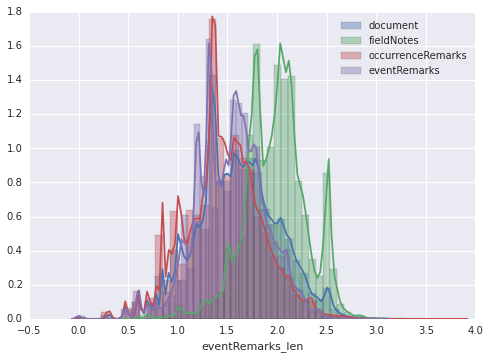

In [14]:
print(type(notes_pd))

# Switched to doing this in Spark to avoid the overhead of copying all the text to Pandas
# I guess there are some None's in the column...
#def wow(r):
#    if r['document'] is None:
#        return 0
#    else:
#        return math.log10(len(r['document']))
#    
#notes_pd['document_len'] = notes_pd.apply(lambda r: wow(r), axis=1) 


#print(notes_pd.head())
sns.distplot(notes_pd['document_len'].dropna().apply(numpy.log10))

sns.distplot(notes_pd['fieldNotes_len'].dropna()[ notes_pd['fieldNotes_len']>0 ].apply(numpy.log10))

sns.distplot(notes_pd['occurrenceRemarks_len'].dropna()[ notes_pd['occurrenceRemarks_len']>0 ].apply(numpy.log10))

ax = sns.distplot(notes_pd['eventRemarks_len'].dropna()[ notes_pd['eventRemarks_len']>0 ].apply(numpy.log10))

labels = ['document', 'fieldNotes', 'occurrenceRemarks','eventRemarks']
ax.legend(labels)

The above shows frequency but remember, we removed all the 0 length strings so the above plot is best read as "I don't often have fieldNotes, but when I do they're 100 characters long." For something a little more representative of the overall data (though still, remember we removed anything with a document_len = 0):

[592034, 2019462, 827645]
['fieldNotes', 'occurrenceRemarks', 'eventRemarks']


(-1.009904422960417, 1.0, -1.0073379019162194, 1.0039291208702286)

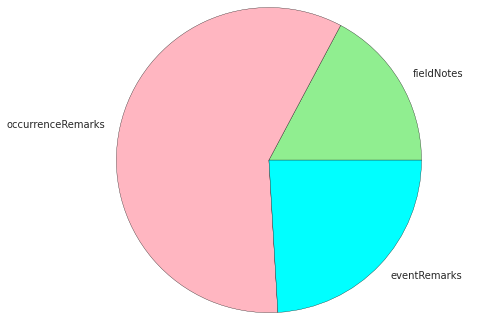

In [15]:
sizes = [notes_pd['fieldNotes_len'].dropna()[ notes_pd['fieldNotes_len']>0 ].size,
        notes_pd['occurrenceRemarks_len'].dropna()[ notes_pd['occurrenceRemarks_len']>0 ].size,
        notes_pd['eventRemarks_len'].dropna()[ notes_pd['eventRemarks_len']>0 ].size]
colors = ['lightgreen', 'lightpink', 'cyan']
print(sizes)
print(labels[1:])
plt.pie(sizes, labels=labels[1:], colors=colors)
plt.axis('equal')

Now let's write out the data set at a parquet for easy loading later. Can skip to this or can not run this if just want to update the graphs.
 

In [16]:
notes.write.parquet('../data/idigbio_notes.parquet')

In [17]:
notes_test = sqlContext.read.parquet("../data/idigbio_notes.parquet")
print(notes_test.count())

3230857
